In [1]:
import sys

sys.path.append('../../')

import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import lightning as L

from sklearn import datasets
from dal_toolbox.models.ensemble import Ensemble, EnsembleTrainer, EnsembleOptimizer

/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


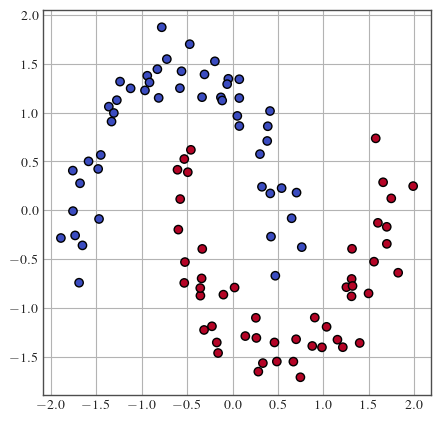

In [2]:
X, y = datasets.make_moons(100, noise=.1, random_state=42)
# X, y = datasets.make_circles(500, noise=.02)
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

train_ds = torch.utils.data.TensorDataset(X, y)

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [3]:
class Net(nn.Module):
    def __init__(self, num_classes: int, dropout_rate: int = .2, feature_dim: int = 128):
        super().__init__()

        self.first = nn.Linear(2, feature_dim)
        self.first_dropout = nn.Dropout(dropout_rate)
        self.hidden = nn.Linear(feature_dim, feature_dim)
        self.hidden_dropout = nn.Dropout(dropout_rate)
        self.last = nn.Linear(feature_dim, num_classes)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.first(x))
        x = self.first_dropout(x)
        x = self.act(self.hidden(x))
        x = self.hidden_dropout(x)
        out = self.last(x)
        return out

    def get_logits(self, dataloader, device):
        logits_list = []
        for inputs, _ in dataloader:
            logits_list.append(self(inputs.to(device)).cpu())
        return torch.cat(logits_list)

In [4]:
@torch.no_grad()
def plot_contour(model, domain=5, ax=None):
    model.eval()
    model.cpu()
    if ax:
        plt.sca(ax)
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model.mc_forward(zz)
    probas = logits.softmax(-1)
    probas = probas.mean(1)
    zz = probas[:, 1].view(xx.shape)

    plt.contourf(xx.numpy(), yy.numpy(), zz.numpy(), alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6))
    plt.colorbar()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | model         | ModuleList        | 171 K 
1 | loss_fn       | CrossEntropyLoss  | 0     
2 | train_metrics | ModuleDict        | 0     
3 | val_metrics   | ModuleDict        | 0     
4 | val_loss_fn   | GibbsCrossEntropy | 0     
----------------------------------------------------
171 K     Trainable params
0         Non-trainable params
171 K     Total params
0.686     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 34.48it/s, v_num=306, train_loss_member0=0.0514, train_loss_member1=0.0392, train_loss_member2=0.0631, train_loss_member3=0.0354, train_loss_member4=0.046, train_loss_member5=0.0494, train_loss_member6=0.0522, train_loss_member7=0.0405, train_loss_member8=0.0445, train_loss_member9=0.0512, val_loss=0.0269] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 33.02it/s, v_num=306, train_loss_member0=0.0514, train_loss_member1=0.0392, train_loss_member2=0.0631, train_loss_member3=0.0354, train_loss_member4=0.046, train_loss_member5=0.0494, train_loss_member6=0.0522, train_loss_member7=0.0405, train_loss_member8=0.0445, train_loss_member9=0.0512, val_loss=0.0269]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


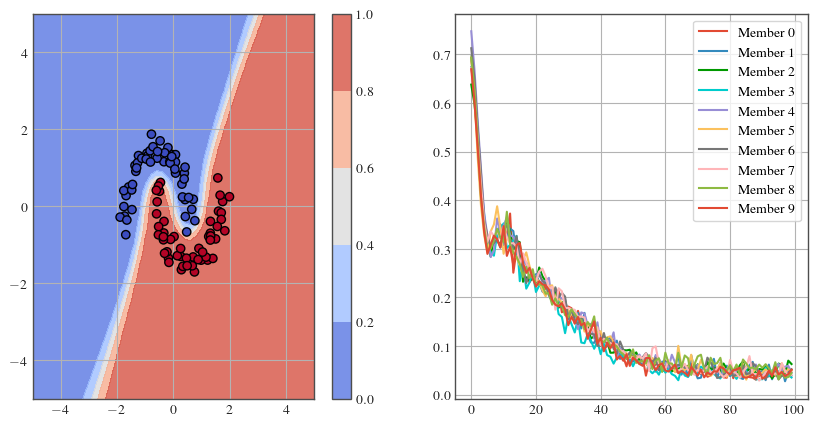

In [5]:
from dal_toolbox.models.ensemble import EnsembleModel
from dal_toolbox.models.utils.callbacks import MetricHistory

num_members = 10
num_epochs = 100
torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)

members = [Net(2) for _ in range(num_members)]
optimizers = [torch.optim.SGD(m.parameters(), lr=1e-1, momentum=0.9) for m in members]
lr_schedulers = [torch.optim.lr_scheduler.CosineAnnealingLR(o, T_max=100) for o in optimizers]
model = EnsembleModel(members, optimizer_list=optimizers, lr_scheduler_list=lr_schedulers)
history = MetricHistory()
trainer = L.Trainer(max_epochs=num_epochs, callbacks=[history], enable_checkpointing=False)
trainer.fit(model, train_loader, val_dataloaders=train_loader)

model.eval()
plt.figure(figsize=(10, 5))
plt.subplot(121)
plot_contour(model)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.subplot(122)
plt.legend()
for i in range(num_members):
    plt.plot([d[f'train_loss_member{i}'] for d in history], label=f'Member {i}')
plt.legend()
plt.show()